# Mutation Analysis

In the [chapter on coverage](Coverage.ipynb), we showed how one can identify which parts of the program are executed by a program, and hence get a sense of the effectiveness of a set of test cases in covering the program structure.  However, coverage alone may not be the best measure for the effectiveness of a test, as one can have great coverage without ever checking a result for correctness.  In this chapter, we introduce another means for assessing the effectiveness of a test suite: After injecting *mutations* – _artificial faults_ – into the code, we check whether a test suite can detect these artificial faults.  The idea is that if it fails to detect such mutations, it will also miss real bugs.

**Prerequisites**

* You need some understanding of how a program is executed.
* You should have read [the chapter on coverage](Coverage.ipynb).

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.MutationAnalysis import <identifier>
```

and then make use of the following features.


This chapter introduces two methods of running *mutation analysis* on subject programs. The first class `MuFunctionAnalyzer` targets individual functions. Given a function `gcd` and two test cases evaluate, one can run mutation analysis on the test cases as follows:

```python
>>> for mutant in MuFunctionAnalyzer(gcd, log=True):
>>>     with mutant:
>>>         assert gcd(1, 0) == 1, "Minimal"
>>>         assert gcd(0, 1) == 1, "Mirror"
>>> mutant.pm.score()
->	gcd_1
<-	gcd_1
Detected gcd_1 <class 'UnboundLocalError'> local variable 'c' referenced before assignment

->	gcd_2
<-	gcd_2
Detected gcd_2 <class 'AssertionError'> Mirror

->	gcd_3
<-	gcd_3

->	gcd_4
<-	gcd_4

->	gcd_5
<-	gcd_5

->	gcd_6
<-	gcd_6

->	gcd_7
<-	gcd_7
Detected gcd_7 <class 'AssertionError'> Minimal


0.42857142857142855
```
The second class `MuProgramAnalyzer` targets standalone programs with test suites. Given a program `gcd` whose source code is provided in `gcd_src` and the test suite is provided by `TestGCD`, one can evaluate the mutation score of `TestGCD` as follows:

```python
>>> class TestGCD(unittest.TestCase):
>>>     def test_simple(self):
>>>         assert cfg.gcd(1, 0) == 1
>>> 
>>>     def test_mirror(self):
>>>         assert cfg.gcd(0, 1) == 1
>>> for mutant in MuProgramAnalyzer('gcd', gcd_src):
>>>     mutant[test_module].runTest('TestGCD')
>>> mutant.pm.score()
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
======================================================================
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)

1.0
```
The mutation score thus obtained is a better indicator of the quality of a given test suite than pure coverage.



## Why Structural Coverage is Not Enough

One of the problems with [structural coverage](Coverage.ipynb) measures is that it fails to check whether the program executions generated by the test suite were actually _correct_. That is, an execution that produces a wrong output that is unnoticed by the test suite is counted exactly the same as an execution that produces the right output for coverage. Indeed, if one deletes the assertions in a typical test case, the coverage would not change for the new test suite, but the new test suite is much less useful than the original one.  As an example, consider this "test":

In [1]:
def ineffective_test_1():
    execute_the_program_as_a_whole()
    assert True

The final assertion here will always pass, no matter what `execute_the_program_as_a_whole()` will do.  Okay, if `execute_the_program_as_a_whole()` raises an exception, the test will fail, but we can also get around that:

In [2]:
def ineffective_test_2():
    try:
        execute_the_program_as_a_whole()
    except:
        pass
    assert True

The problem with these "tests", however, is that `execute_the_program_as_a_whole()` may achieve 100% code coverage (or 100% of any other structural coverage metric).  Yet, this number of 100% does not reflect the ability of the test to discover bugs, which actually is 0%.

This is indeed, not an optimal state of affairs. How can we verify that our tests are actually useful? One alternative (hinted in the chapter on coverage) is to inject bugs into the program, and evaluate the effectiveness of test suites in catching these injected bugs. However, that introduces another problem. How do we produce these bugs in the first place? Any manual effort is likely to be biased by the preconceptions of the developer as to where the bugs are likely to occur, and what effect it would have. Further, writing good bugs is likely to take a significant amount of time, for a very indirect benefit. Hence, such a solution is not sufficient.

## Seeding Artificial Faults with Mutation Analysis

Mutation Analysis offers an alternative solution to assess the effectiveness of a test suite.  The idea of mutation analysis is to seed _artificial faults_, known as *mutations*, into the program code, and to check whether the test suite finds them.  Such a mutation could, for instance, replace a `+` by a `-` somewhere within `execute_the_program_as_a_whole()`.  Of course, the above ineffective tests would not detect this, as they do not check any of the results.  An effective test would, however; and the assumption is that the more effective a test is in finding _artificial_ faults, the more effective it would be in finding _real_ faults.

The insight from Mutation Analysis is to consider the probability of insertion of a bug from the perspective of a programmer. If one assumes that the attention received by each program element in the program is sufficiently similar, one can further assume that each token in the program has a similar probability of being incorrectly transcribed. Of course, the programmer will correct any mistakes that gets detected by the compilers (or other static analysis tools). So the set of valid tokens different from the original that make it past the compilation stage is considered to be its possible set of _mutations_ that represent the _probable faults_ in the program. A test suite is then judged by its capability to detect (and hence prevent) such mutations. The proportion of such mutants detected over all _valid_ mutants produced is taken as the mutation score. In this chapter, we see how one can implement Mutation Analysis in Python programs. The mutation score obtained represents the ability of any program analysis tools to prevent faults, and can be used to judge static test suites, test generators such as fuzzers, and also static and symbolic execution frameworks.

It might be intuitive to consider a slightly different perspective. A test suite is a program that can be considered to accept as its input, the program to be tested.  What is the best way to evaluate such a program (the test suite)? We can essentially *fuzz* the test suite by applying small mutations to the input program, and verifying that the test suite in question does not produce unexpected behaviors. The test suite is supposed to only allow the original through; and hence any mutant that is not detected as faulty represents a bug in the test suite.

## Structural Coverage Adequacy by Example

Let us introduce a more detailed example to illustrate both the problems with coverage as well as how mutation analysis works.  The `triangle()` program below classifies a triangle with edge lengths $a$, $b$, and $c$ into the proper triangle category.  We want to verify that the program works correctly.

In [3]:
def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

Here are a few test cases to ensure that the program works.

In [4]:
def strong_oracle(fn):
    assert fn(1, 1, 1) == 'Equilateral'

    assert fn(1, 2, 1) == 'Isosceles'
    assert fn(2, 2, 1) == 'Isosceles'
    assert fn(1, 2, 2) == 'Isosceles'

    assert fn(1, 2, 3) == 'Scalene'

Running them actually causes all tests to pass.

In [5]:
strong_oracle(triangle)

However, the statement that "all tests pass" has value only if we know that our tests are effective.
What is the effectiveness of our test suite? As we saw in the [chapter on coverage](Coverage.ipynb), one can use structural coverage techniques such as statement coverage to obtain a measure of effectiveness of the test case.

In [6]:
import bookutils.setup

In [7]:
from Coverage import Coverage

In [8]:
import inspect

We add a function `show_coverage()` to visualize the coverage obtained.

In [9]:
class VisualCoverage(Coverage):
    def show_coverage(self, fn):
        src = inspect.getsource(fn)
        name = fn.__name__
        covered = set([lineno for method,
                       lineno in self._trace if method == name])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

In [10]:
with VisualCoverage() as cov:
    strong_oracle(triangle)

In [11]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return 'Equilateral'
   5:         else:
#  6:             return 'Isosceles'
   7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
  10:         else:
# 11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
# 14:                 return "Scalene"
  15: 


Our `strong_oracle()` seems to have adequately covered all possible conditions.
That is, our set of test cases is reasonably good according to structural coverage. However, does the coverage obtained tell the whole story? Consider this test suite instead:

In [12]:
def weak_oracle(fn):
    assert fn(1, 1, 1) == 'Equilateral'

    assert fn(1, 2, 1) != 'Equilateral'
    assert fn(2, 2, 1) != 'Equilateral'
    assert fn(1, 2, 2) != 'Equilateral'

    assert fn(1, 2, 3) != 'Equilateral'

All that we are checking here is that a triangle with unequal sides is not equilateral. What is the coverage obtained?

In [13]:
with VisualCoverage() as cov:
    weak_oracle(triangle)

In [14]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return 'Equilateral'
   5:         else:
#  6:             return 'Isosceles'
   7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
  10:         else:
# 11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
# 14:                 return "Scalene"
  15: 


Indeed, there does not seem to be _any_ difference in coverage.
The `weak_oracle()` obtains exactly the same coverage as that of `strong_oracle()`. However, a moment's reflection should convince one that the `weak_oracle()` is not as effective as `strong_oracle()`. However, _coverage_ is unable to distinguish between the two test suites. What are we missing in coverage?
The problem here is that coverage is unable to evaluate the _quality_ of our assertions. Indeed, coverage does not care about assertions at all. However, as we saw above, assertions are an extremely important part of test suite effectiveness. Hence, what we need is a way to evaluate the quality of assertions.

## Injecting Artificial Faults

Notice that in the [chapter on coverage](Coverage.ipynb), coverage was presented as a _proxy_ for the likelihood of a test suite to uncover bugs. What if we actually try to evaluate the likelihood of a test suite to uncover bugs? All we need is to inject bugs into the program, one at a time, and count the number of such bugs that our test suite detects. The frequency of detection will provide us with the actual likelihood of the test suite to uncover bugs. This technique is called _fault injection_. Here is an example for _fault injection_.

In [15]:
def triangle_m1(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            # return 'Isosceles'
            return None  # <-- injected fault
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

Let us see if our test suites are good enough to catch this fault. We first check whether `weak_oracle()` can detect this change.

In [16]:
from ExpectError import ExpectError

In [17]:
with ExpectError():
    weak_oracle(triangle_m1)

The `weak_oracle()` is unable to detect any changes. What about our `strong_oracle()`?

In [18]:
with ExpectError():
    strong_oracle(triangle_m1)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/3191755624.py", line 2, in <cell line: 1>
    strong_oracle(triangle_m1)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/566939880.py", line 5, in strong_oracle
    assert fn(2, 2, 1) == 'Isosceles'
AssertionError (expected)


Our `strong_oracle()` is able to detect this fault, which is evidence that `strong_oracle()` is probably a better test suite.

_Fault injection_ can provide a good measure of effectiveness of a test suite, provided we have a list of possible faults. The problem is that collecting such a set of _unbiased_ faults is rather expensive. It is difficult to create good faults that are reasonably hard to detect, and it is a manual process. Given that it is a manual process, the generated faults will be biased by the preconceptions of the developer who creates it. Even when such curated faults are available, they are unlikely to be exhaustive, and likely to miss important classes of bugs, and parts of the program. Hence, _fault injection_ is an insufficient replacement for coverage. Can we do better?

Mutation Analysis provides an alternative to a curated set of faults. The key insight is that, if one assumes that the programmer understands the program in question, the majority of errors made are very likely small transcription errors (a few tokens). A compiler will likely catch most of these errors. Hence, the majority of residual faults in a program is likely to be due to small (single token) variations at certain points in the structure of the program from the correct program (This particular assumption is called the *Competent Programmer Hypothesis* or the *Finite Neighborhood Hypothesis*).

What about the larger faults composed of multiple smaller faults? The key insight here is that, for a majority of such complex faults, test cases that detect a single smaller fault in isolation is very likely to detect the larger complex fault that contains it. (This assumption is called the *Coupling Effect*.)

How can we use these assumptions in practice? The idea is to simply generate *all* possible *valid* variants of the program that differs from the original by a small change (such as a single token change) (Such variants are called *mutants*). Next, the given test suite is applied to each variant thus generated. Any mutant detected by the test suite is said to have been *killed* by the test suite. The effectiveness of a test suite is given by the proportion of mutants killed to the valid mutants generated.

We next implement a simple mutation analysis framework and use it to evaluate our test suites.

## Mutating Python Code

To manipulate a Python program, we work on the _abstract syntax tree_ (AST) representation – which is the internal representation compilers and interpreters work on after reading in the program text.

Briefly speaking, we convert the program into a tree, and then _change parts of this tree_ – for instance, by changing `+` operators into `-` or vice versa, or actual statements into `pass` statements that do nothing.  The resulting mutated tree can then be processed further; it can be passed on to the Python interpreter for execution, or we can _unparse_ it back into a textual form.

We begin by importing the AST manipulation modules.

In [19]:
import ast
import inspect

We can get the source of a Python function using `inspect.getsource()`.  (Note that this does not work for functions defined in other notebooks.)

In [20]:
triangle_source = inspect.getsource(triangle)
triangle_source

'def triangle(a, b, c):\n    if a == b:\n        if b == c:\n            return \'Equilateral\'\n        else:\n            return \'Isosceles\'\n    else:\n        if b == c:\n            return "Isosceles"\n        else:\n            if a == c:\n                return "Isosceles"\n            else:\n                return "Scalene"\n'

To view these in a visually pleasing form, our function `print_content(s, suffix)` formats and highlights the string `s` as if it were a file with ending `suffix`.  We can thus view (and highlight) the source as if it were a Python file:

In [21]:
from bookutils import print_content

In [22]:
print_content(triangle_source, '.py')

def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

Parsing this gives us an abstract syntax tree (AST) – a representation of the program in tree form.

In [23]:
triangle_ast = ast.parse(triangle_source)

What does this AST look like?  The helper functions `ast.dump()` (textual output) and `showast.show_ast()` (graphical output with [showast](https://github.com/hchasestevens/show_ast)) allow us to inspect the structure of the tree.  We see that the function starts as a `FunctionDef` with name and arguments, followed by a body, which is a list of statements; in this case, the body contains only an `If`, which itself contains other nodes of type `If`, `Compare`, `Name`, `Str`, and `Return`.

In [24]:
print(ast.dump(triangle_ast, indent=4))

Module(
    body=[
        FunctionDef(
            name='triangle',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='a'),
                    arg(arg='b'),
                    arg(arg='c')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                If(
                    test=Compare(
                        left=Name(id='a', ctx=Load()),
                        ops=[
                            Eq()],
                        comparators=[
                            Name(id='b', ctx=Load())]),
                    body=[
                        If(
                            test=Compare(
                                left=Name(id='b', ctx=Load()),
                                ops=[
                                    Eq()],
                                comparators=[
                                    Name(id='c', ctx=Load())]),
              

Too much text for you?  This graphical representation may make things simpler.

In [25]:
from bookutils import rich_output

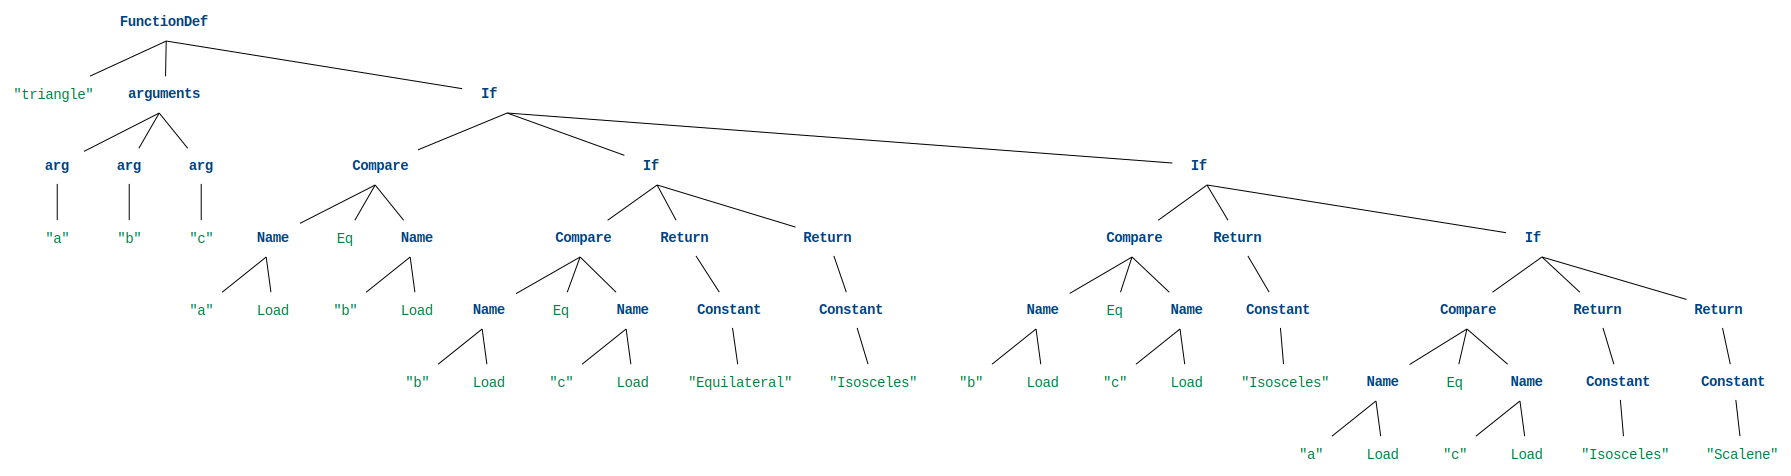

In [26]:
if rich_output():
    import showast
    showast.show_ast(triangle_ast)

The function `ast.unparse()` converts such a tree back into the more familiar textual Python code representation.

In [27]:
print_content(ast.unparse(triangle_ast), '.py')

def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    elif b == c:
        return 'Isosceles'
    elif a == c:
        return 'Isosceles'
    else:
        return 'Scalene'

## A Simple Mutator for Functions

Let us now go and mutate the `triangle()` program. A simple way to produce valid mutated version of this program is to replace some of its statements by `pass`.

The `MuFunctionAnalyzer` is the main class responsible for mutation analysis of the test suite. It accepts the function to be tested. It normalizes the source code given by parsing and unparsing it once, using the functions discussed above. This is required to ensure that later `diff`s between the original and mutant are not derailed by differences in whitespace, comments, etc.

In [28]:
class MuFunctionAnalyzer:
    def __init__(self, fn, log=False):
        self.fn = fn
        self.name = fn.__name__
        src = inspect.getsource(fn)
        self.ast = ast.parse(src)
        self.src = ast.unparse(self.ast)  # normalize
        self.mutator = self.mutator_object()
        self.nmutations = self.get_mutation_count()
        self.un_detected = set()
        self.mutants = []
        self.log = log

    def mutator_object(self, locations=None):
        return StmtDeletionMutator(locations)

    def register(self, m):
        self.mutants.append(m)

    def finish(self):
        pass

The `get_mutation_count()` fetches the number of possible mutations available. We will see later how this can be implemented.

In [29]:
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def get_mutation_count(self):
        self.mutator.visit(self.ast)
        return self.mutator.count

The `Mutator` provides the base class for implementing individual mutations. It accepts a list of locations to mutate. It assumes that the method `mutable_visit()` is invoked on all nodes of interest as determined by the subclass. When the `Mutator` is invoked without a list of locations to mutate, it simply loops through all possible mutation points and retains a count in `self.count`. If it is invoked with a specific list of locations to mutate, the `mutable_visit()` method calls the `mutation_visit()` which performs the mutation on the node. Note that a single location can produce multiple mutations. (Hence the hashmap).

In [30]:
class Mutator(ast.NodeTransformer):
    def __init__(self, mutate_location=-1):
        self.count = 0
        self.mutate_location = mutate_location

    def mutable_visit(self, node):
        self.count += 1  # statements start at line no 1
        if self.count == self.mutate_location:
            return self.mutation_visit(node)
        return self.generic_visit(node)

The `StmtDeletionMutator` simply hooks into all the statement processing visitors. It performs mutation by replacing the given statement with `pass`.  As you can see, it visits all kinds of statements.

In [31]:
class StmtDeletionMutator(Mutator):
    def visit_Return(self, node): return self.mutable_visit(node)
    def visit_Delete(self, node): return self.mutable_visit(node)

    def visit_Assign(self, node): return self.mutable_visit(node)
    def visit_AnnAssign(self, node): return self.mutable_visit(node)
    def visit_AugAssign(self, node): return self.mutable_visit(node)

    def visit_Raise(self, node): return self.mutable_visit(node)
    def visit_Assert(self, node): return self.mutable_visit(node)

    def visit_Global(self, node): return self.mutable_visit(node)
    def visit_Nonlocal(self, node): return self.mutable_visit(node)

    def visit_Expr(self, node): return self.mutable_visit(node)

    def visit_Pass(self, node): return self.mutable_visit(node)
    def visit_Break(self, node): return self.mutable_visit(node)
    def visit_Continue(self, node): return self.mutable_visit(node)

The actual mutation consists of replacing the node with a `pass` statement:

In [32]:
class StmtDeletionMutator(StmtDeletionMutator):
    def mutation_visit(self, node): return ast.Pass()    

For `triangle()`, this visitor produces five mutations – namely, replacing the five `return` statements with `pass`:

In [33]:
MuFunctionAnalyzer(triangle).nmutations

5

We need a way to obtain the individual mutants. For this, we convert our `MuFunctionAnalyzer` to an *iterable*.

In [34]:
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def __iter__(self):
        return PMIterator(self)

The `PMIterator`, which is the *iterator* class for `MuFunctionAnalyzer` is defined as follows.

In [35]:
class PMIterator:
    def __init__(self, pm):
        self.pm = pm
        self.idx = 0

The `next()` method returns the corresponding `Mutant`:

In [36]:
class PMIterator(PMIterator):
    def __next__(self):
        i = self.idx
        if i >= self.pm.nmutations:
            self.pm.finish()
            raise StopIteration()
        self.idx += 1
        mutant = Mutant(self.pm, self.idx, log=self.pm.log)
        self.pm.register(mutant)
        return mutant

The `Mutant` class contains logic for generating mutants when given the locations to mutate.

In [37]:
class Mutant:
    def __init__(self, pm, location, log=False):
        self.pm = pm
        self.i = location
        self.name = "%s_%s" % (self.pm.name, self.i)
        self._src = None
        self.tests = []
        self.detected = False
        self.log = log

Here is how it can be used:

In [38]:
for m in MuFunctionAnalyzer(triangle):
    print(m.name)

triangle_1
triangle_2
triangle_3
triangle_4
triangle_5


These names are a bit generic yet.  Let's see whether we can get more insights into the mutations produced.

The `generate_mutant()` simply calls the `mutator()` method, and passes the mutator a copy of the AST. 

In [39]:
class Mutant(Mutant):
    def generate_mutant(self, location):
        mutant_ast = self.pm.mutator_object(
            location).visit(ast.parse(self.pm.src))  # copy
        return ast.unparse(mutant_ast)

The `src()` method returns the mutated source.

In [40]:
class Mutant(Mutant):
    def src(self):
        if self._src is None:
            self._src = self.generate_mutant(self.i)
        return self._src

Here is how one can obtain the mutants, and visualize the difference from the original:

In [41]:
import difflib

In [42]:
for mutant in MuFunctionAnalyzer(triangle):
    shape_src = mutant.pm.src
    for line in difflib.unified_diff(mutant.pm.src.split('\n'),
                                     mutant.src().split('\n'),
                                     fromfile=mutant.pm.name,
                                     tofile=mutant.name, n=3):
        print(line)

--- triangle

+++ triangle_1

@@ -1,7 +1,7 @@

 def triangle(a, b, c):
     if a == b:
         if b == c:
-            return 'Equilateral'
+            pass
         else:
             return 'Isosceles'
     elif b == c:
--- triangle

+++ triangle_2

@@ -3,7 +3,7 @@

         if b == c:
             return 'Equilateral'
         else:
-            return 'Isosceles'
+            pass
     elif b == c:
         return 'Isosceles'
     elif a == c:
--- triangle

+++ triangle_3

@@ -5,7 +5,7 @@

         else:
             return 'Isosceles'
     elif b == c:
-        return 'Isosceles'
+        pass
     elif a == c:
         return 'Isosceles'
     else:
--- triangle

+++ triangle_4

@@ -7,6 +7,6 @@

     elif b == c:
         return 'Isosceles'
     elif a == c:
-        return 'Isosceles'
+        pass
     else:
         return 'Scalene'
--- triangle

+++ triangle_5

@@ -9,4 +9,4 @@

     elif a == c:
         return 'Isosceles'
     else:
-        return 'Scalene'
+        pass


In this `diff` output, lines prefixed with `+` are added, whereas lines prefixed with `-` are deleted.  We see that each of the five mutants indeed replaces a return statement with a `pass` statement.

We add the `diff()` method to `Mutant` so that it can be called directly.

In [43]:
class Mutant(Mutant):
    def diff(self):
        return '\n'.join(difflib.unified_diff(self.pm.src.split('\n'),
                                              self.src().split('\n'),
                                              fromfile='original',
                                              tofile='mutant',
                                              n=3))

## Evaluating Mutations

We are now ready to implement the actual evaluation. We define our mutant as a _context manager_ that verifies whether all assertions given succeed.  The idea is that we can write code such as

```python
for mutant in MuFunctionAnalyzer(function):
    with mutant:
        assert function(x) == y
```

and while `mutant` is active (i.e., the code block under `with:`), the original function is replaced by the mutated function.

The `__enter__()` function is called when the `with` block is entered.  It creates the mutant as a Python function and places it in the global namespace, such that the `assert` statement executes the mutated function rather than the original.

In [44]:
class Mutant(Mutant):
    def __enter__(self):
        if self.log:
            print('->\t%s' % self.name)
        c = compile(self.src(), '<mutant>', 'exec')
        eval(c, globals())

The `__exit__()` function checks whether an exception has occurred (i.e., the assertion failed, or some other error was raised); if so, it marks the mutation as `detected`.  Finally, it restores the original function definition.

In [45]:
class Mutant(Mutant):
    def __exit__(self, exc_type, exc_value, traceback):
        if self.log:
            print('<-\t%s' % self.name)
        if exc_type is not None:
            self.detected = True
            if self.log:
                print("Detected %s" % self.name, exc_type, exc_value)
        globals()[self.pm.name] = self.pm.fn
        if self.log:
            print()
        return True

The `finish()` method simply invokes the method on the mutant, checks if the mutant was discovered, and returns the result.

In [46]:
from ExpectError import ExpectTimeout

In [47]:
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def finish(self):
        self.un_detected = {
            mutant for mutant in self.mutants if not mutant.detected}

The mutation score – the ratio of mutants detected by the test suite - is computed by `score()`.  A score of 1.0 means that all mutants were discovered; a score of 0.1 means that only 10% of mutants were detected.

In [48]:
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def score(self):
        return (self.nmutations - len(self.un_detected)) / self.nmutations

Here is how we use our framework.

In [49]:
import sys

In [50]:
for mutant in MuFunctionAnalyzer(triangle, log=True):
    with mutant:
        assert triangle(1, 1, 1) == 'Equilateral', "Equal Check1"
        assert triangle(1, 0, 1) != 'Equilateral', "Equal Check2"
        assert triangle(1, 0, 2) != 'Equilateral', "Equal Check3"
mutant.pm.score()

->	triangle_1
<-	triangle_1
Detected triangle_1 <class 'AssertionError'> Equal Check1

->	triangle_2
<-	triangle_2

->	triangle_3
<-	triangle_3

->	triangle_4
<-	triangle_4

->	triangle_5
<-	triangle_5



0.2

Only one out of five mutations resulted in a failing assertion.  Hence, the `weak_oracle()` test suite gets a mutation score of 20%.

In [51]:
for mutant in MuFunctionAnalyzer(triangle):
    with mutant:
        weak_oracle(triangle)
mutant.pm.score()

0.2

Since we are modifying the global namespace, we do not have to refer to the function directly within the for loop of mutant.

In [52]:
def oracle():
    strong_oracle(triangle)

In [53]:
for mutant in MuFunctionAnalyzer(triangle, log=True):
    with mutant:
        oracle()
mutant.pm.score()

->	triangle_1
<-	triangle_1
Detected triangle_1 <class 'AssertionError'> 

->	triangle_2
<-	triangle_2
Detected triangle_2 <class 'AssertionError'> 

->	triangle_3
<-	triangle_3
Detected triangle_3 <class 'AssertionError'> 

->	triangle_4
<-	triangle_4
Detected triangle_4 <class 'AssertionError'> 

->	triangle_5
<-	triangle_5
Detected triangle_5 <class 'AssertionError'> 



1.0

That is, we were able to achieve `100%` mutation score with the `strong_oracle()` test suite.

Here is another example. `gcd()` computes the greatest common divisor of two numbers.

In [54]:
def gcd(a, b):
    if a < b:
        c = a
        a = b
        b = c

    while b != 0:
        c = a
        a = b
        b = c % b

    return a

Here's a test for it.  How effective is it?

In [55]:
for mutant in MuFunctionAnalyzer(gcd, log=True):
    with mutant:
        assert gcd(1, 0) == 1, "Minimal"
        assert gcd(0, 1) == 1, "Mirror"

->	gcd_1
<-	gcd_1
Detected gcd_1 <class 'UnboundLocalError'> local variable 'c' referenced before assignment

->	gcd_2
<-	gcd_2
Detected gcd_2 <class 'AssertionError'> Mirror

->	gcd_3
<-	gcd_3

->	gcd_4
<-	gcd_4

->	gcd_5
<-	gcd_5

->	gcd_6
<-	gcd_6

->	gcd_7
<-	gcd_7
Detected gcd_7 <class 'AssertionError'> Minimal



In [56]:
mutant.pm.score()

0.42857142857142855

We see that our `TestGCD` test suite is able to obtain a mutation score of 42%.

## Mutator for Modules and Test Suites

Consider the `triangle()` program we discussed previously. As we discussed, a simple way to produce valid mutated version of this program is to replace some of its statements by `pass`.

For demonstration purposes, we would like to proceed as though the program was in a different file. We can do that by producing a `Module` object in Python, and attaching the function to it.

In [57]:
import types

In [58]:
def import_code(code, name):
    module = types.ModuleType(name)
    exec(code, module.__dict__)
    return module

We attach the `triangle()` function to the `shape` module.

In [59]:
shape = import_code(shape_src, 'shape')

We can now invoke triangle through the module `shape`.

In [60]:
shape.triangle(1, 1, 1)

'Equilateral'

We want to test the `triangle()` function. For that, we define a `StrongShapeTest` class as below.

In [61]:
import unittest

In [62]:
class StrongShapeTest(unittest.TestCase):

    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == 'Equilateral'

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) == 'Isosceles'
        assert shape.triangle(2, 2, 1) == 'Isosceles'
        assert shape.triangle(1, 2, 2) == 'Isosceles'

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) == 'Scalene'

We define a helper function `suite()` that looks through a given class and identifies the test functions.

In [63]:
def suite(test_class):
    suite = unittest.TestSuite()
    for f in test_class.__dict__:
        if f.startswith('test_'):
            suite.addTest(test_class(f))
    return suite

The tests in `TestTriangle` class can be invoked with different test runners. The simplest is to directly invoke the `run()` method of the `TestCase`.

In [64]:
suite(StrongShapeTest).run(unittest.TestResult())

<unittest.result.TestResult run=3 errors=0 failures=0>

The `TextTestRunner` class provides ability to control the verbosity of execution. It also allows one to return on the *first* failure.

In [65]:
runner = unittest.TextTestRunner(verbosity=0, failfast=True)
runner.run(suite(StrongShapeTest))

----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

Running the program under coverage is accomplished as follows:

In [66]:
with VisualCoverage() as cov:
    suite(StrongShapeTest).run(unittest.TestResult())

The coverage obtained is given by:

In [67]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return 'Equilateral'
   5:         else:
#  6:             return 'Isosceles'
#  7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
# 10:         else:
  11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
  14:                 return "Scalene"
  15: 


In [68]:
class WeakShapeTest(unittest.TestCase):
    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == 'Equilateral'

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) != 'Equilateral'
        assert shape.triangle(2, 2, 1) != 'Equilateral'
        assert shape.triangle(1, 2, 2) != 'Equilateral'

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) != 'Equilateral'

How much coverage does it obtain?

In [69]:
with VisualCoverage() as cov:
    suite(WeakShapeTest).run(unittest.TestResult())

In [70]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return 'Equilateral'
   5:         else:
#  6:             return 'Isosceles'
#  7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
# 10:         else:
  11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
  14:                 return "Scalene"
  15: 


The `MuProgramAnalyzer` is the main class responsible for mutation analysis of the test suite. It accepts the name of the module to be tested, and its source code. It normalizes the source code given by parsing and unparsing it once. This is required to ensure that later `diff`s between the original and mutant are not derailed by differences in whitespace, comments, etc.

In [71]:
class MuProgramAnalyzer(MuFunctionAnalyzer):
    def __init__(self, name, src):
        self.name = name
        self.ast = ast.parse(src)
        self.src = ast.unparse(self.ast)
        self.changes = []
        self.mutator = self.mutator_object()
        self.nmutations = self.get_mutation_count()
        self.un_detected = set()

    def mutator_object(self, locations=None):
        return AdvStmtDeletionMutator(self, locations)

We now extend the `Mutator` class.

In [72]:
class AdvMutator(Mutator):
    def __init__(self, analyzer, mutate_locations=None):
        self.count = 0
        self.mutate_locations = [] if mutate_locations is None else mutate_locations
        self.pm = analyzer

    def mutable_visit(self, node):
        self.count += 1  # statements start at line no 1
        return self.mutation_visit(node)

The `AdvStmtDeletionMutator` simply hooks into all the statement processing visitors. It performs mutation by replacing the given statement with `pass`.

In [73]:
class AdvStmtDeletionMutator(AdvMutator, StmtDeletionMutator):
    def __init__(self, analyzer, mutate_locations=None):
        AdvMutator.__init__(self, analyzer, mutate_locations)

    def mutation_visit(self, node):
        index = 0  # there is only one way to delete a statement -- replace it by pass
        if not self.mutate_locations:  # counting pass
            self.pm.changes.append((self.count, index))
            return self.generic_visit(node)
        else:
            # get matching changes for this pass
            mutating_lines = set((count, idx)
                                 for (count, idx) in self.mutate_locations)
            if (self.count, index) in mutating_lines:
                return ast.Pass()
            else:
                return self.generic_visit(node)

Aagin, we can obtain the number of mutations produced for `triangle()` as follows.

In [74]:
MuProgramAnalyzer('shape', shape_src).nmutations

5

We need a way to obtain the individual mutants. For this, we convert our `MuProgramAnalyzer` to an *iterable*.

In [75]:
class MuProgramAnalyzer(MuProgramAnalyzer):
    def __iter__(self):
        return AdvPMIterator(self)

The `AdvPMIterator`, which is the *iterator* class for `MuProgramAnalyzer` is defined as follows.

In [76]:
class AdvPMIterator:
    def __init__(self, pm):
        self.pm = pm
        self.idx = 0

The `next()` method returns the corresponding `Mutant`

In [77]:
class AdvPMIterator(AdvPMIterator):
    def __next__(self):
        i = self.idx
        if i >= len(self.pm.changes):
            raise StopIteration()
        self.idx += 1
        # there could be multiple changes in one mutant
        return AdvMutant(self.pm, [self.pm.changes[i]])

The `Mutant` class contains logic for generating mutants when given the locations to mutate.

In [78]:
class AdvMutant(Mutant):
    def __init__(self, pm, locations):
        self.pm = pm
        self.i = locations
        self.name = "%s_%s" % (self.pm.name,
                               '_'.join([str(i) for i in self.i]))
        self._src = None

Here is how it can be used:

In [79]:
shape_src = inspect.getsource(triangle)

In [80]:
for m in MuProgramAnalyzer('shape', shape_src):
    print(m.name)

shape_(1, 0)
shape_(2, 0)
shape_(3, 0)
shape_(4, 0)
shape_(5, 0)


The `generate_mutant()` simply calls the `mutator()` method, and passes the mutator a copy of the AST. 

In [81]:
class AdvMutant(AdvMutant):
    def generate_mutant(self, locations):
        mutant_ast = self.pm.mutator_object(
            locations).visit(ast.parse(self.pm.src))  # copy
        return ast.unparse(mutant_ast)

The `src()` method returns the mutated source.

In [82]:
class AdvMutant(AdvMutant):
    def src(self):
        if self._src is None:
            self._src = self.generate_mutant(self.i)
        return self._src

Again, we visualize mutants as difference from the original:

In [83]:
import difflib

We add the `diff()` method to `Mutant` so that it can be called directly.

In [84]:
class AdvMutant(AdvMutant):
    def diff(self):
        return '\n'.join(difflib.unified_diff(self.pm.src.split('\n'),
                                              self.src().split('\n'),
                                              fromfile='original',
                                              tofile='mutant',
                                              n=3))

In [85]:
for mutant in MuProgramAnalyzer('shape', shape_src):
    print(mutant.name)
    print(mutant.diff())
    break

shape_(1, 0)
--- original

+++ mutant

@@ -1,7 +1,7 @@

 def triangle(a, b, c):
     if a == b:
         if b == c:
-            return 'Equilateral'
+            pass
         else:
             return 'Isosceles'
     elif b == c:


We are now ready to implement the actual evaluation. For doing that, we require the ability to accept the module where the test suite is defined, and invoke the test method on it. The method `getitem` accepts the test module, fixes the import entries on the test module to correctly point to the mutant module, and passes it to the test runner `MutantTestRunner`.

In [86]:
class AdvMutant(AdvMutant):
    def __getitem__(self, test_module):
        test_module.__dict__[
            self.pm.name] = import_code(
            self.src(), self.pm.name)
        return MutantTestRunner(self, test_module)

The `MutantTestRunner` simply calls all `test_` methods on the test module, checks if the mutant was discovered, and returns the result.

In [87]:
from ExpectError import ExpectTimeout

In [88]:
class MutantTestRunner:
    def __init__(self, mutant, test_module):
        self.mutant = mutant
        self.tm = test_module

    def runTest(self, tc):
        suite = unittest.TestSuite()
        test_class = self.tm.__dict__[tc]
        for f in test_class.__dict__:
            if f.startswith('test_'):
                suite.addTest(test_class(f))
        runner = unittest.TextTestRunner(verbosity=0, failfast=True)
        try:
            with ExpectTimeout(1):
                res = runner.run(suite)
                if res.wasSuccessful():
                    self.mutant.pm.un_detected.add(self)
                return res
        except SyntaxError:
            print('Syntax Error (%s)' % self.mutant.name)
            return None
        raise Exception('Unhandled exception during test execution')

The mutation score is computed by `score()`.

In [89]:
class MuProgramAnalyzer(MuProgramAnalyzer):
    def score(self):
        return (self.nmutations - len(self.un_detected)) / self.nmutations

Here is how we use our framework.

In [90]:
import sys

In [91]:
test_module = sys.modules[__name__]
for mutant in MuProgramAnalyzer('shape', shape_src):
    mutant[test_module].runTest('WeakShapeTest')
mutant.pm.score()

FAIL: test_equilateral (__main__.WeakShapeTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/511514204.py", line 3, in test_equilateral
    assert shape.triangle(1, 1, 1) == 'Equilateral'
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK


0.2

The `WeakShape` test suite resulted in only `20%` mutation score.

In [92]:
for mutant in MuProgramAnalyzer('shape', shape_src):
    mutant[test_module].runTest('StrongShapeTest')
mutant.pm.score()

FAIL: test_equilateral (__main__.StrongShapeTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2670057129.py", line 4, in test_equilateral
    assert shape.triangle(1, 1, 1) == 'Equilateral'
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
FAIL: test_isosceles (__main__.StrongShapeTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2670057129.py", line 8, in test_isosceles
    assert shape.triangle(2, 2, 1) == 'Isosceles'
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.000s

FAILED (failures=1)
FAIL: test_isosceles (__main__.StrongShapeTest)
-------------------------------------------------

1.0

On the other hand, we were able to achieve `100%` mutation score with `StrongShapeTest` test suite.

Here is another example, `gcd()`.

In [93]:
gcd_src = inspect.getsource(gcd)

In [94]:
class TestGCD(unittest.TestCase):
    def test_simple(self):
        assert cfg.gcd(1, 0) == 1

    def test_mirror(self):
        assert cfg.gcd(0, 1) == 1

In [95]:
for mutant in MuProgramAnalyzer('cfg', gcd_src):
    mutant[test_module].runTest('TestGCD')
mutant.pm.score()

ERROR: test_mirror (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 6, in test_mirror
    assert cfg.gcd(0, 1) == 1
  File "<string>", line 5, in gcd
UnboundLocalError: local variable 'c' referenced before assignment

----------------------------------------------------------------------
Ran 2 tests in 0.000s

FAILED (errors=1)
FAIL: test_mirror (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 6, in test_mirror
    assert cfg.gcd(0, 1) == 1
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.000s

FAILED (failures=1)
----------------------------------------------------------------------
Ran 2 tests in

0.42857142857142855

We see that our `TestGCD` test suite is able to obtain `42%` mutation score.

## The Problem of  Equivalent Mutants

One of the problems with mutation analysis is that not all mutants generated need to be faulty. For example, consider the `new_gcd()` program below.

In [96]:
def new_gcd(a, b):
    if a < b:
        a, b = b, a
    else:
        a, b = a, b

    while b != 0:
        a, b = b, a % b
    return a

This program can be mutated to produce the following mutant.

In [97]:
def mutated_gcd(a, b):
    if a < b:
        a, b = b, a
    else:
        pass

    while b != 0:
        a, b = b, a % b
    return a

In [98]:
for i, mutant in enumerate(MuFunctionAnalyzer(new_gcd)):
    print(i,mutant.src())

0 def new_gcd(a, b):
    if a < b:
        pass
    else:
        (a, b) = (a, b)
    while b != 0:
        (a, b) = (b, a % b)
    return a
1 def new_gcd(a, b):
    if a < b:
        (a, b) = (b, a)
    else:
        pass
    while b != 0:
        (a, b) = (b, a % b)
    return a
2 def new_gcd(a, b):
    if a < b:
        (a, b) = (b, a)
    else:
        (a, b) = (a, b)
    while b != 0:
        pass
    return a
3 def new_gcd(a, b):
    if a < b:
        (a, b) = (b, a)
    else:
        (a, b) = (a, b)
    while b != 0:
        (a, b) = (b, a % b)
    pass


While other mutants are faulty compared to the original, `mutant 1` is indistinguishable from the original in terms of its semantics because it removes an inconsequential assignment. This means that `mutant 1` does not represent a fault. These kinds of mutants that do not represent a fault are called *Equivalent mutants*. The problem with equivalent mutants is that it becomes very difficult to judge the mutation score in the presence of equivalent mutants. For example, with a mutation score of 70%, anywhere from 0 to 30% of the mutants may be equivalent. Hence, without knowing the actual number of equivalent mutants, it is impossible to judge how much the tests can be improved. We discuss two methods to deal with equivalent mutants.

### Statistical Estimation of Number of Equivalent Mutants

If the number of mutants that are alive is small enough, one may rely on simply inspecting them manually. However, if the number of mutants are sufficiently large (say > 1000), one may choose a smaller number of mutants from the alive mutants randomly and manually evaluate them to see whether they represent faults. The sample size determination is governed by the following formula for a binomial distribution (approximated by a normal distribution):

$$
n \ge \hat{p}(1-\hat{p})\bigg(\frac{Z_{\frac{\alpha}{2}}}{\Delta}\bigg)^2
$$

where $n$ is the number of samples, $p$ is the parameter for the probability distribution, $\alpha$ is the accuracy desired, $\Delta$ the precision. For an accuracy of $95\%$, $Z_{0.95}=1.96$. we have the following values (the maximum value of $\hat{p}(1-\hat{p}) = 0.25$) and $Z$ is the critical value for normal distribution:

$$
n \ge 0.25\bigg(\frac{1.96}{\Delta}\bigg)^2
$$

For $\Delta = 0.01$, (that is for a maximum error of 1%), we need to evaluate $9604$ mutants for equivalence. If one relaxes the constraint to $\Delta = 0.1$ (that is an error of $10\%$), then one needs to evaluate only $96$ mutants for equivalence.

### Statistical Estimation of the Number of Immortals by Chao's Estimator

While the idea of sampling only a limited number of mutants is appealing, it is still limited in that manual analysis is necessary. If computing power is cheap, another way to estimate the number of true mutants (and hence the number of equivalent mutants) is by means of Chao's estimator. As we will see in the chapter on [when to stop fuzzing](WhenToStopFuzzing.ipynb), the formula is given by:

$$
\hat S_\text{Chao1} = \begin{cases}
S(n) + \frac{f_1^2}{2f_2} & \text{if $f_2>0$}\\
S(n) + \frac{f_1(f_1-1)}{2} & \text{otherwise}
\end{cases}
$$

The basic idea is to compute the result of the complete test matrix $T \times M$ of each test against each mutant. The variable $f_1$ represents the number of mutants that were killed exactly once, and the variable $f_2$ represents the number of variables that were killed exactly twice. $S(n)$ is the total number of mutants killed. Here, $\hat{S}_{Chao1}$ provides the estimate of the true number of mutants. If $M$ is the total mutants generated, then $M - \hat{S}_{Chao1}$ represents the number of **immortal** mutants. Note that these **immortal** mutants are somewhat different from the traditional equivalent mutants in that the **mortality** depends on the oracle used to distinguish variant behavior. That is, if one uses a fuzzer that relies on errors thrown to detect killing, it will not detect mutants that produce different output but does not throw an error. Hence, the *Chao1* estimate will essentially be the asymptote value of mutants the fuzzer can detect if it is given an infinite amount of time. The **immortal** mutant estimate will approach true **equivalent** mutant estimate when the oracle used is sufficiently strong.
For more details see the chapter on [when to stop fuzzing](WhenToStopFuzzing.ipynb). A comprehensive guide to species discovery in testing is the paper by Boehme \cite{boehme2018species}.

## Synopsis

This chapter introduces two methods of running *mutation analysis* on subject programs. The first class `MuFunctionAnalyzer` targets individual functions. Given a function `gcd` and two test cases evaluate, one can run mutation analysis on the test cases as follows:

In [99]:
for mutant in MuFunctionAnalyzer(gcd, log=True):
    with mutant:
        assert gcd(1, 0) == 1, "Minimal"
        assert gcd(0, 1) == 1, "Mirror"
mutant.pm.score()

->	gcd_1
<-	gcd_1
Detected gcd_1 <class 'UnboundLocalError'> local variable 'c' referenced before assignment

->	gcd_2
<-	gcd_2
Detected gcd_2 <class 'AssertionError'> Mirror

->	gcd_3
<-	gcd_3

->	gcd_4
<-	gcd_4

->	gcd_5
<-	gcd_5

->	gcd_6
<-	gcd_6

->	gcd_7
<-	gcd_7
Detected gcd_7 <class 'AssertionError'> Minimal



0.42857142857142855

The second class `MuProgramAnalyzer` targets standalone programs with test suites. Given a program `gcd` whose source code is provided in `gcd_src` and the test suite is provided by `TestGCD`, one can evaluate the mutation score of `TestGCD` as follows:

In [100]:
class TestGCD(unittest.TestCase):
    def test_simple(self):
        assert cfg.gcd(1, 0) == 1

    def test_mirror(self):
        assert cfg.gcd(0, 1) == 1

In [101]:
for mutant in MuProgramAnalyzer('gcd', gcd_src):
    mutant[test_module].runTest('TestGCD')
mutant.pm.score()

FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_27362/2565918356.py", line 3, in test_simple
    assert cfg.gcd(1, 0) == 1
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
FAIL: test_simple (__main__.TestGCD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n2/xd944

1.0

The mutation score thus obtained is a better indicator of the quality of a given test suite than pure coverage.

## Lessons Learned

* We have learned why structural coverage is insufficient to evaluate the quality of test suites.
* We have learned how to use Mutation Analysis for evaluating test suite quality.
* We have learned the limitations of Mutation Analysis -- Equivalent and Redundant mutants, and how to estimate them.

## Next Steps

* While naive fuzzing generates poor quality oracles, techniques such as [symbolic](SymbolicFuzzer.ipynb) and [concolic](ConcolicFuzzer.ipynb) can enhance the quality oracles used in fuzzing.
* [Dynamic invariants](DynamicInvariants.ipynb) can also be of great help in improving the quality of oracles.
* The chapter on [when to stop fuzzing](WhenToStopFuzzing.ipynb) provides a detailed overview of the Chao estimator.

## Background

The idea of Mutation Analysis was first introduced by Lipton et al. \cite{lipton1971fault}. An excellent survey of mutation analysis research was published by Jia et al. \cite{jia2011analysis}. The chapter on Mutation Analysis by Papadakis et al \cite{papadakis2019mutation} is another excellent overview of the current trends in mutation analysis.

## Exercises

### Exercise 1: Arithmetic Expression Mutators

Our simple statement deletion mutation is only one of the ways in which a program could be mutated. Another category of mutants is _expression mutation_ where arithmetic operators such as `{+,-,*,/}` etc. are replaced for one another. For example, given an expression such as
```
x = x + 1
```
One can mutate it to
```
x = x - 1
```
and
```
x = x * 1
```
and
```
x = x / 1
```

First, we need to find out which node types we want to mutate. We get these via the ast functions and find that the node type is named BinOp

In [102]:
print(ast.dump(ast.parse("1 + 2 - 3 * 4 / 5"), indent=4))

Module(
    body=[
        Expr(
            value=BinOp(
                left=BinOp(
                    left=Constant(value=1),
                    op=Add(),
                    right=Constant(value=2)),
                op=Sub(),
                right=BinOp(
                    left=BinOp(
                        left=Constant(value=3),
                        op=Mult(),
                        right=Constant(value=4)),
                    op=Div(),
                    right=Constant(value=5))))],
    type_ignores=[])


To mutate the tree, you thus need to change the `op` attribute (which has one of the values `Add`, `Sub`, `Mult`, and `Div`)

**Solution.** First, we need to find out which node types we want to mutate.  We get these via the `ast` functions and find that the node type is named `BinOp`

In [103]:
print(ast.dump(ast.parse("1 + 2 - 3 * 4 / 5"), indent=4))

Module(
    body=[
        Expr(
            value=BinOp(
                left=BinOp(
                    left=Constant(value=1),
                    op=Add(),
                    right=Constant(value=2)),
                op=Sub(),
                right=BinOp(
                    left=BinOp(
                        left=Constant(value=3),
                        op=Mult(),
                        right=Constant(value=4)),
                    op=Div(),
                    right=Constant(value=5))))],
    type_ignores=[])


To mutate the tree, we need to change the `op` attribute (which has one of the values `Add`, `Sub`, `Mult`, and `Div`).  Write a class `BinOpMutator` that does the necessary mutations, and then create a  class `MuBinOpAnalyzer` as subclass of `MuFunctionAnalyzer` which makes use of `BinOpMutator`.

**Solution.** As with `StmtDeletionMutator`, we have to visit the AST – in this case, all `BinOp` nodes – and make appropriate changes:

In [104]:
class BinOpMutator(Mutator):
    def visit_BinOp(self, node): return self.mutable_visit(node)

In [105]:
class BinOpMutator(BinOpMutator):
    def mutation_visit(self, node):
        replacement = {
            type(ast.Add()): ast.Sub(),
            type(ast.Sub()): ast.Add(),
            type(ast.Mult()): ast.Div(),
            type(ast.Div()): ast.Mult()
        }

        try:
            node.op = replacement[type(node.op)]
        except KeyError:
            pass  # All other binary operators (and, mod, etc.)

        return node

We hook this into our own analyzer:

In [106]:
class MuBinOpAnalyzer(MuFunctionAnalyzer):
    def mutator_object(self, locations=None):
        return BinOpMutator(locations)

Here's how it mutates a function:

In [107]:
def arith_expr():
    return 1 + 2 - 3 * 4 / 5

In [108]:
for mutant in MuBinOpAnalyzer(arith_expr, log=True):
    print(mutant.diff())

--- original

+++ mutant

@@ -1,2 +1,2 @@

 def arith_expr():
-    return 1 + 2 - 3 * 4 / 5
+    return 1 + 2 + 3 * 4 / 5
--- original

+++ mutant

@@ -1,2 +1,2 @@

 def arith_expr():
-    return 1 + 2 - 3 * 4 / 5
+    return 1 - 2 - 3 * 4 / 5
--- original

+++ mutant

@@ -1,2 +1,2 @@

 def arith_expr():
-    return 1 + 2 - 3 * 4 / 5
+    return 1 + 2 - 3 * 4 * 5
--- original

+++ mutant

@@ -1,2 +1,2 @@

 def arith_expr():
-    return 1 + 2 - 3 * 4 / 5
+    return 1 + 2 - 3 / 4 / 5


### Exercise 2: Optimizing Mutation Analysis

Our technique for mutation analysis is somewhat inefficient in that we run the tests even on mutants that have mutations in code not covered by the test case. Test cases have no possibility of detecting errors on portions of code they do not cover. Hence, one of the simplest optimizations is to first recover the coverage information from the given test case, and only run the test case on mutants where the mutations lie in the code being covered by the test case. Can you modify the `MuFunctionAnalyzer` to incorporate recovering coverage as the first step?

**Solution.** Left to the astute reader.

### Exercise 3: Byte Code Mutator

We have seen how to mutate the AST given the source. One of the deficiencies with this approach is that the Python bytecode is targeted by other languages too. In such cases, the source may not be readily converted to a Python AST, and it is desirable to mutate the bytecode instead. Can you implement a bytecode mutator for Python function that mutates the bytecode instead of fetching the source and then mutating it?

**Solution.** Left to the astute reader.

### Exercise 4: Estimating Residual Defect Density

The defect density of a program is the number of defects in a program that that were detected before release divided by the program size. The residual defect density is the percentage of defects that escaped detection. While estimation of the real residual defect density is difficult, mutation analysis can provide an upper bound. The number of mutants that remain undetected is a plausible upper bound on the number of defects that remain within the program. However, this upper bound may be too wide. The reason is that some remaining faults can interact with each other, and if present together, can be detected by the available test suite. Hence, a tighter bound is the number of mutants that can exist *together* in a given program without being detected by the given test suite. This can be accomplished by starting with the complete set of mutations possible, and applying delta-debugging from [the chapter on reducing](Reducer.ipynb) to determine the minimum number of mutations that need to be removed to make the mutant pass undetected by the test suite. Can you produce a new `RDDEstimator` by extending the `MuFunctionAnalyzer` that estimates the residual defect density upper bound using this technique?

**Solution.** Left to the astute reader.